In [1]:
import os
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

from scipy.interpolate import interp1d
from scipy.signal import butter, sosfiltfilt
from pydub import AudioSegment
AudioSegment.converter = 'C:\\ffmpeg-2024-09-05-git-3d0d0f68d5-full_build\\bin\\ffmpeg.exe'
AudioSegment.ffprobe = 'C:\\ffmpeg-2024-09-05-git-3d0d0f68d5-full_build\\bin\\ffprobe.exe'

import librosa

color = ['#E84A4E', '#51546B', '#616EEB', '#E8C54A', '#4AE875', '#94885F', '#6B4545']


natural_notes = ['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3',
                 'C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                 'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5',
                 'C6', 'D6', 'E6', 'F6', 'G6', 'A6', 'B6'
                 ]
note_freqs = {
    'C3': 130.81,
    'D3': 146.83,
    'E3': 164.81,
    'F3': 174.61,
    'G3': 196.00,
    'A3': 220.00,
    'B3': 246.94,
    'C4': 261.63,
    'D4': 293.66,
    'E4': 329.63,
    'F4': 349.23,
    'G4': 392.00,
    'A4': 440.00,
    'B4': 493.88,
    'C5': 523.25,
    'D5': 587.33,
    'E5': 659.25,
    'F5': 698.46,
    'G5': 783.99,
    'A5': 880.00,
    'B5': 987.77,
    'C6': 1046.50,
    'D6': 1174.66,
    'E6': 1318.51,
    'F6': 1396.91,
    'G6': 1567.98,
    'A6': 1760.00,
    'B6': 1975.53
}

In [33]:
path = '../dataset/revision/'
target_date = '2024-08-12'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,5.979,0.4389,0.5398,0.1780,0.4561,-1.0595,6.4718,180.0876
1,6.028,0.4384,0.5399,0.1761,0.4560,-0.8981,7.1419,180.1376
2,6.078,0.4385,0.5399,0.1758,0.4560,-0.8437,7.9602,180.1347
3,6.128,0.4384,0.5399,0.1766,0.4561,-1.0247,8.5293,180.2354
4,6.178,0.4383,0.5399,0.1760,0.4563,-1.2691,9.0962,180.2350
...,...,...,...,...,...,...,...,...
12281,963.178,0.4038,0.5481,0.2839,0.4633,-0.9163,50.2852,94.4888
12282,963.228,0.4030,0.5480,0.2841,0.4631,-0.2081,50.1978,95.0078
12283,963.278,0.4028,0.5479,0.2843,0.4631,0.3667,50.2312,95.5391
12284,963.328,0.4028,0.5478,0.2843,0.4634,-0.5126,50.3408,94.8635


In [34]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [35]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,5.979,0.438900,0.539800,0.178000,0.456100,-1.059500,6.471800,180.087600
1,5.980,0.438887,0.539804,0.177888,0.456096,-1.049486,6.518270,180.086592
2,5.981,0.438874,0.539807,0.177779,0.456092,-1.039741,6.563907,180.085691
3,5.982,0.438862,0.539810,0.177674,0.456088,-1.030262,6.608719,180.084896
4,5.983,0.438850,0.539814,0.177572,0.456084,-1.021046,6.652716,180.084206
...,...,...,...,...,...,...,...,...
957345,963.324,0.402878,0.547874,0.284701,0.463518,-0.085391,50.209149,95.249080
957346,963.325,0.402882,0.547879,0.284719,0.463515,-0.039246,50.201299,95.288207
957347,963.326,0.402886,0.547884,0.284739,0.463512,0.008993,50.193182,95.329085
957348,963.327,0.402891,0.547889,0.284759,0.463508,0.059360,50.184795,95.371742


In [36]:
# butterworth filter
cutoff = [0.1, 20]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,-0.000738,0.000407,-0.004450,0.000374,2.866711,-8.910557,0.094773
1,0.001,-0.000749,0.000410,-0.004544,0.000371,2.876859,-8.876859,0.094362
2,0.002,-0.000761,0.000413,-0.004638,0.000368,2.887058,-8.842813,0.093967
3,0.003,-0.000773,0.000416,-0.004732,0.000365,2.897279,-8.808539,0.093593
4,0.004,-0.000784,0.000420,-0.004826,0.000362,2.907491,-8.774152,0.093246
...,...,...,...,...,...,...,...,...
957345,957.345,-0.000029,-0.000050,-0.000119,0.000011,-0.307289,0.073725,-0.250963
957346,957.346,-0.000026,-0.000045,-0.000106,0.000010,-0.275687,0.065911,-0.225193
957347,957.347,-0.000023,-0.000040,-0.000094,0.000009,-0.244889,0.058365,-0.200067
957348,957.348,-0.000020,-0.000035,-0.000082,0.000008,-0.215132,0.051132,-0.175781


(831.0, 900.0)

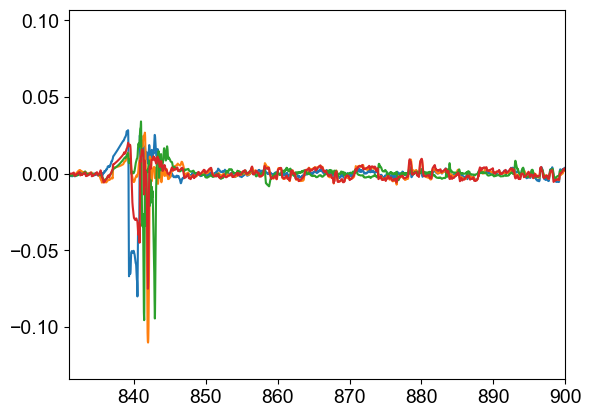

In [37]:
plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
plt.xlim(831, 900)
# plt.ylim(-0.01, 0.01)

# Swallow

## level 3

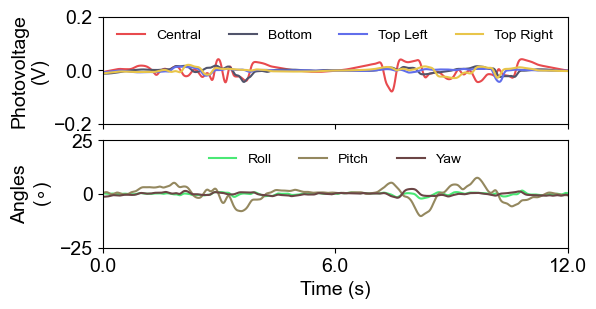

In [154]:
start = 155
offset = 20

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl3.png', bbox_inches='tight', dpi=600)
plt.show()

## level 4

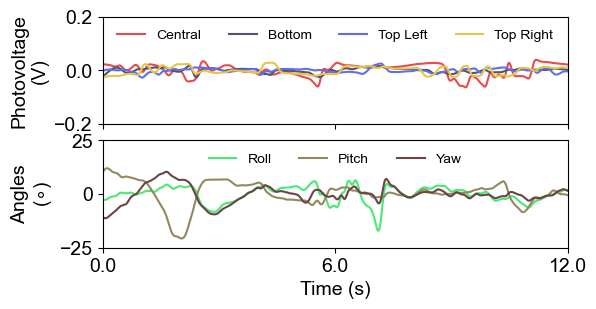

In [155]:
start = 155
offset = 116

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl4.png', bbox_inches='tight', dpi=600)
plt.show()

## level 5

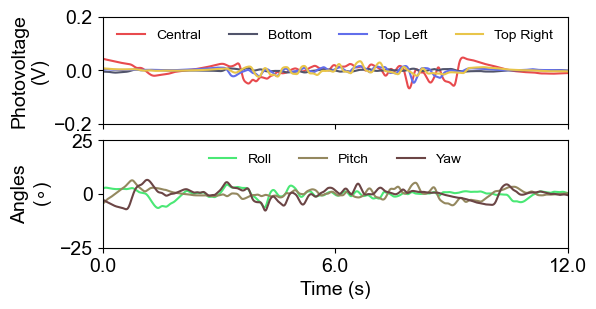

In [156]:
start = 155
offset = 197

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl5.png', bbox_inches='tight', dpi=600)
plt.show()

## level 6

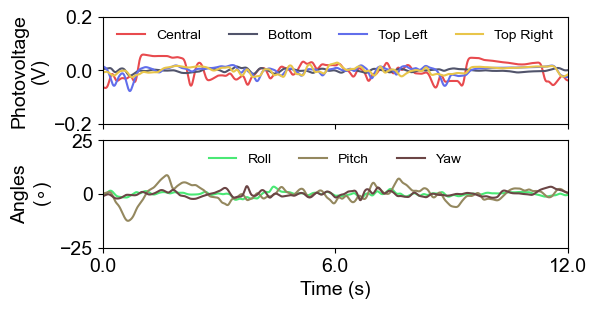

In [157]:
start = 155
offset = 260

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl6.png', bbox_inches='tight', dpi=600)
plt.show()

## level 7

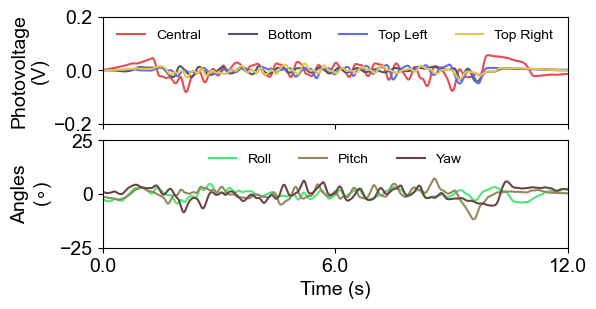

In [158]:
start = 155
offset = 303

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl7.png', bbox_inches='tight', dpi=600)
plt.show()

# Phonetics

## Pitch

In [20]:
# audio = AudioSegment.from_file('../dataset/revision/voice.m4a')
# audio.export('../dataset/revision/voice.wav', format='wav')

In [38]:
y, sr = librosa.load('../dataset/revision/voice.wav', sr=None)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, n_fft=8192, hop_length=1024)
S_dB = librosa.power_to_db(S, ref=np.max)

natural_notes = ['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4']
note_freqs = {
    'C3': 130.81,
    'D3': 146.83,
    'E3': 164.81,
    'F3': 174.61,
    'G3': 196.00,
    'A3': 220.00,
    'B3': 246.94,
    'C4': 261.63,
    'D4': 293.66,
    'E4': 329.63,
    'F4': 349.23,
    'G4': 392.00,
    'A4': 440.00,
    'B4': 493.88
}

### C3

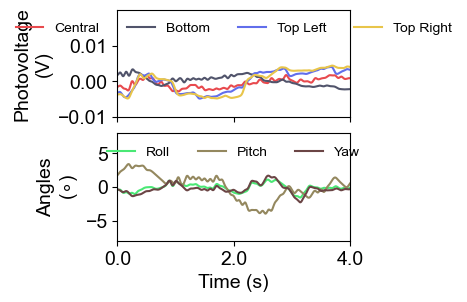

In [41]:
start = 832
offset = 29.5

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.02)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/quality/c3.svg', bbox_inches='tight', dpi=600)
plt.show()

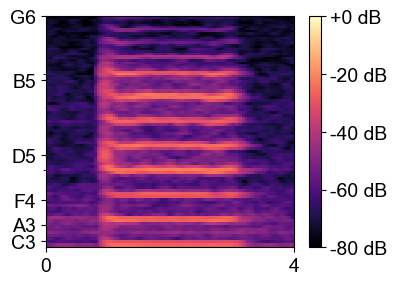

In [44]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.xlim(15, 16)
plt.ylim(100, 1000)

plt.xticks([15, 16], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::5], list(note_freqs.keys())[0::5],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/c3_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### G3

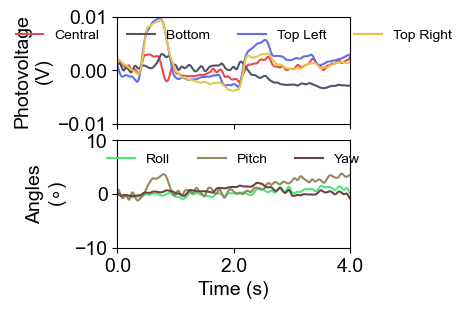

In [46]:
start = 832
offset = 47.3

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.01)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/quality/g3.svg', bbox_inches='tight', dpi=600)
plt.show()

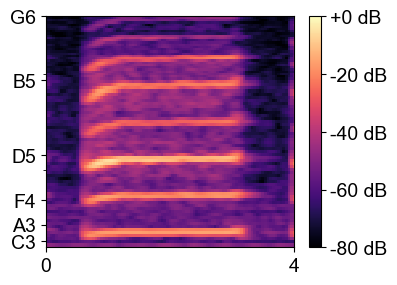

In [47]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.xlim(23.2, 24.2)
plt.ylim(100, 1000)

plt.xticks([23.2, 24.2], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::5], list(note_freqs.keys())[0::5],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/g3_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### G4

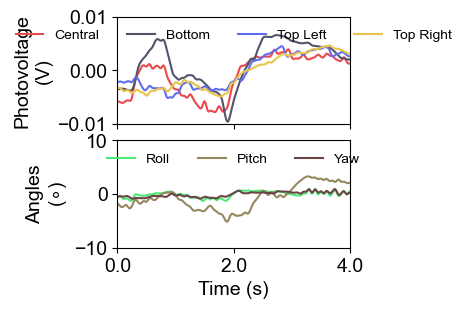

In [48]:
start = 832
offset = 81

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.01)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/quality/g4.svg', bbox_inches='tight', dpi=600)
plt.show()

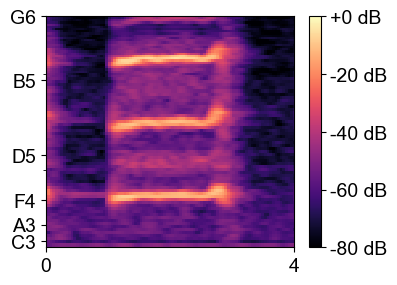

In [49]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 40.8
xr = 41.8

plt.xlim(xl, xr)
plt.ylim(100, 1000)

plt.xticks([xl, xr], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::5], list(note_freqs.keys())[0::5],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/g4_spec.png', bbox_inches='tight', dpi=600)
plt.show()

## Style

### whisper

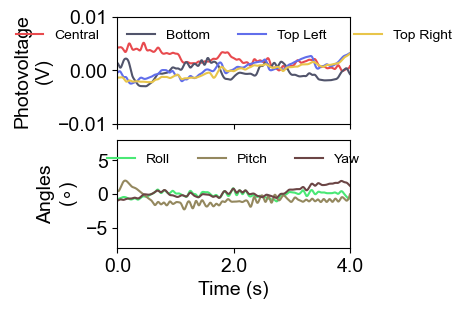

In [51]:
start = 832
offset = 95

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.01)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/quality/whisper.svg', bbox_inches='tight', dpi=600)
plt.show()

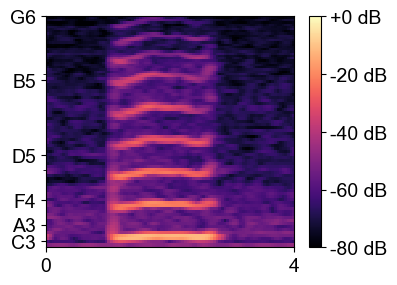

In [53]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 47.8
xr = 48.8

plt.xlim(xl, xr)
plt.ylim(100, 1000)

plt.xticks([xl, xr], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::5], list(note_freqs.keys())[0::5],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/whisper_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### loud

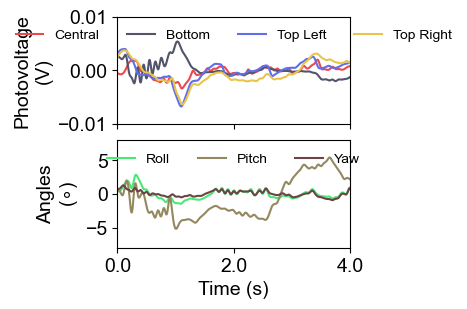

In [55]:
start = 832
offset = 103.5

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.01)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/quality/loud.svg', bbox_inches='tight', dpi=600)
plt.show()

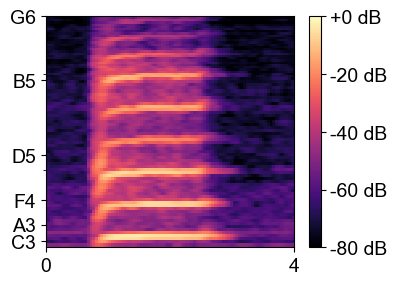

In [56]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 52.5
xr = 53.5

plt.xlim(xl, xr)
plt.ylim(100, 1000)

plt.xticks([xl, xr], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::5], list(note_freqs.keys())[0::5],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/loud_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### Falsetto

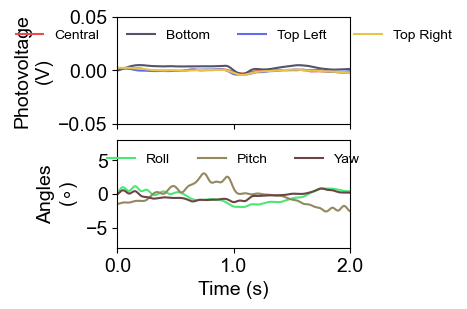

In [57]:
start = 832
offset = 113

start += offset
length = 2

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.05, 0.05)
ax1.set_yticks([-0.05, 0, 0.05])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/quality/falsetto.svg', bbox_inches='tight', dpi=600)
plt.show()

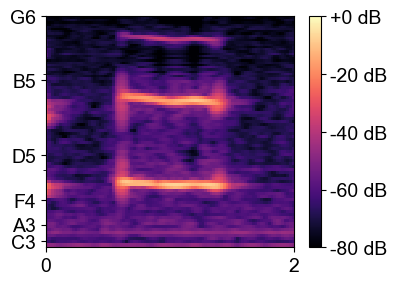

In [58]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 57.2
xr = 58.2

plt.xlim(xl, xr)
plt.ylim(100, 1000)

plt.xticks([xl, xr], labels=[0, 2])
plt.yticks(list(note_freqs.values())[0::5], list(note_freqs.keys())[0::5],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/falsetto_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### Head voice

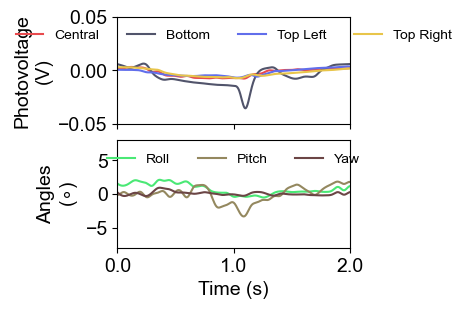

In [59]:
start = 832
offset = 120.5

start += offset
length = 2

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.05, 0.05)
ax1.set_yticks([-0.05, 0, 0.05])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/quality/head_voice.svg', bbox_inches='tight', dpi=600)
plt.show()

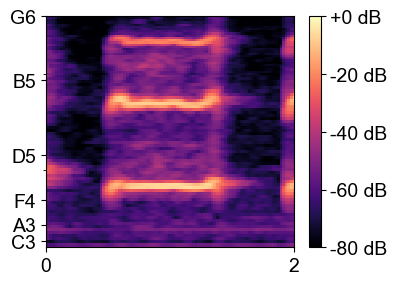

In [60]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 60.3
xr = 61.3

plt.xlim(xl, xr)
plt.ylim(100, 1000)

plt.xticks([xl, xr], labels=[0, 2])
plt.yticks(list(note_freqs.values())[0::5], list(note_freqs.keys())[0::5],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/head_voice_spec.png', bbox_inches='tight', dpi=600)
plt.show()

# Breath

In [2]:
path = '../dataset/revision/'
target_date = '2024-08-23'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,25.128,0.3710,0.1471,0.3640,0.4725,-0.0558,63.4530,198.5810
1,25.178,0.3711,0.1471,0.3643,0.4728,0.6491,63.1988,199.1660
2,25.228,0.3719,0.1471,0.3645,0.4734,-0.4192,63.5120,198.2778
3,25.278,0.3719,0.1476,0.3646,0.4736,0.3990,63.3529,199.0543
4,25.328,0.3723,0.1479,0.3650,0.4739,-1.0483,63.5712,197.8486
...,...,...,...,...,...,...,...,...
735,61.878,0.3744,0.2234,0.3640,0.4648,-1.3687,83.3044,240.8203
736,61.928,0.3741,0.2214,0.3629,0.4633,-3.2422,82.9466,238.9311
737,61.978,0.3738,0.2235,0.3619,0.4631,-1.6537,83.4323,240.5576
738,62.028,0.3738,0.2226,0.3611,0.4635,1.4162,83.8795,243.6635


In [3]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [4]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,25.128,0.371000,0.147100,0.364000,0.472500,-0.055800,63.453000,198.581000
1,25.129,0.370987,0.147110,0.364013,0.472501,-0.013406,63.435582,198.616459
2,25.130,0.370975,0.147119,0.364025,0.472502,0.027616,63.418801,198.650764
3,25.131,0.370963,0.147128,0.364037,0.472503,0.067281,63.402650,198.683926
4,25.132,0.370952,0.147136,0.364049,0.472505,0.105603,63.387119,198.715957
...,...,...,...,...,...,...,...,...
36896,62.024,0.373554,0.222374,0.360880,0.463792,-0.376310,83.629289,241.969164
36897,62.025,0.373541,0.222425,0.360884,0.463794,-0.512678,83.613328,241.836522
36898,62.026,0.373528,0.222480,0.360889,0.463796,-0.654206,83.596846,241.698805
36899,62.027,0.373514,0.222538,0.360894,0.463798,-0.800959,83.579838,241.555952


In [5]:
# butterworth filter
cutoff = [0.1, 5]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,0.000522,-0.005610,0.000004,0.000796,3.188671,-6.624286,2.676009
1,0.001,0.000523,-0.005613,0.000009,0.000801,3.200117,-6.632488,2.685072
2,0.002,0.000524,-0.005616,0.000013,0.000806,3.211463,-6.640661,2.694050
3,0.003,0.000525,-0.005618,0.000018,0.000811,3.222697,-6.648801,2.702934
4,0.004,0.000527,-0.005621,0.000023,0.000816,3.233808,-6.656904,2.711714
...,...,...,...,...,...,...,...,...
36896,36.896,0.000007,0.000041,0.000006,-0.000007,0.010273,0.003891,0.008879
36897,36.897,0.000006,0.000035,0.000005,-0.000006,0.009329,0.003412,0.008123
36898,36.898,0.000005,0.000030,0.000004,-0.000005,0.008369,0.002963,0.007334
36899,36.899,0.000005,0.000025,0.000004,-0.000004,0.007410,0.002546,0.006532


In [6]:
color = ['#E84A4E', '#51546B', '#616EEB', '#E8C54A', '#4AE875', '#94885F', '#6B4545']

(-0.01, 0.01)

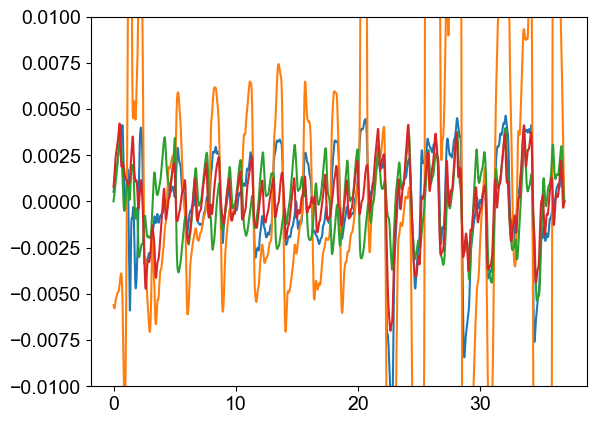

In [7]:
plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
# plt.xlim(112.5, 115.5)
plt.ylim(-0.01, 0.01)

## nasal

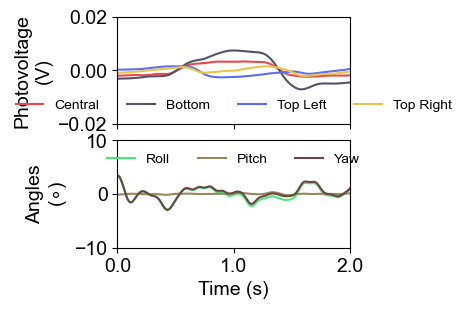

In [11]:
start = 12.5
offset = 0

start += offset
length = 2

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.02, 0.02)
ax1.set_yticks([-0.02, 0, 0.02])
ax1.legend(ncols=4, loc='lower center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/breathing/nasal.svg', bbox_inches='tight', dpi=600)
plt.show()

## oral

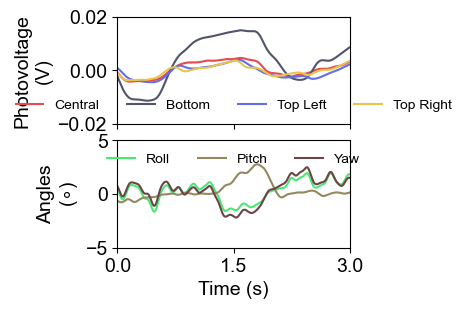

In [12]:
start = 30.5
offset = 0

start += offset
length = 3

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.02, 0.02)
ax1.set_yticks([-0.02, 0, 0.02])
ax1.legend(ncols=4, loc='lower center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-5, 5)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/breathing/oral.svg', bbox_inches='tight', dpi=600)
plt.show()

# Anti-motion

In [14]:
path = '../dataset/revision/'
target_date = '2024-08-24'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,19.078,0.3350,0.5689,0.3206,0.4370,-7.5050,74.2508,208.1015
1,19.128,0.3356,0.5703,0.3149,0.4369,-8.2195,72.8894,208.1069
2,19.178,0.3396,0.5688,0.3113,0.4381,-9.1681,71.8635,207.7493
3,19.228,0.3389,0.5699,0.3104,0.4385,-9.1849,70.9669,207.9350
4,19.278,0.3465,0.5728,0.3105,0.4384,-9.5470,70.3148,207.9052
...,...,...,...,...,...,...,...,...
754,56.778,0.3703,0.5148,0.3428,0.3424,-0.3008,51.3953,272.1389
755,56.828,0.3711,0.5131,0.3415,0.3425,-0.4541,50.8946,272.0355
756,56.878,0.3716,0.5139,0.3410,0.3434,-0.2660,50.5476,272.1417
757,56.928,0.3713,0.5115,0.3409,0.3436,-0.0794,50.0972,272.4583


In [15]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [16]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,19.078,0.335000,0.568900,0.320600,0.437000,-7.505000,74.250800,208.101500
1,19.079,0.334865,0.568994,0.320472,0.436968,-7.505250,74.220440,208.111903
2,19.080,0.334737,0.569085,0.320345,0.436937,-7.506305,74.190205,208.121752
3,19.081,0.334618,0.569172,0.320218,0.436908,-7.508151,74.160095,208.131055
4,19.082,0.334507,0.569256,0.320091,0.436880,-7.510773,74.130110,208.139822
...,...,...,...,...,...,...,...,...
37846,56.924,0.371088,0.510430,0.340814,0.344603,-0.272037,50.621714,272.221652
37847,56.925,0.371091,0.510467,0.340811,0.344650,-0.282339,50.652764,272.204400
37848,56.926,0.371093,0.510508,0.340807,0.344699,-0.292948,50.684853,272.186497
37849,56.927,0.371096,0.510552,0.340804,0.344749,-0.303867,50.717994,272.167933


In [17]:
# butterworth filter
cutoff = [0.1, 20]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,-0.001112,-0.000248,0.012035,-0.001604,-2.790632,1.623446,-3.504111
1,0.001,-0.001202,-0.000175,0.011920,-0.001628,-2.796439,1.595155,-3.499029
2,0.002,-0.001292,-0.000102,0.011804,-0.001651,-2.802453,1.566527,-3.493963
3,0.003,-0.001380,-0.000028,0.011686,-0.001675,-2.808704,1.537623,-3.488952
4,0.004,-0.001467,0.000045,0.011568,-0.001698,-2.815223,1.508502,-3.484040
...,...,...,...,...,...,...,...,...
37846,37.846,0.000004,-0.000268,0.000007,-0.000279,0.074461,-0.215112,0.127578
37847,37.847,0.000003,-0.000242,0.000006,-0.000250,0.066614,-0.192583,0.114248
37848,37.848,0.000002,-0.000217,0.000005,-0.000222,0.059023,-0.170747,0.101318
37849,37.849,0.000002,-0.000191,0.000005,-0.000195,0.051736,-0.149752,0.088879


In [18]:
color = ['#E84A4E', '#51546B', '#616EEB', '#E8C54A', '#4AE875', '#94885F', '#6B4545']

(33.5, 35.0)

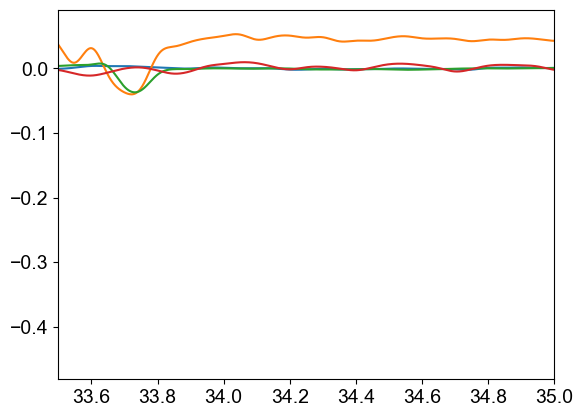

In [19]:
plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
plt.xlim(33.5, 35)
# plt.ylim(-0.01, 0.01)

## stable

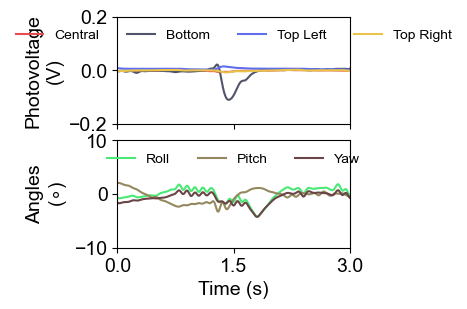

In [20]:
start = 10.5
offset = 0

start += offset
length = 3

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/anti-motion/stable.svg', bbox_inches='tight', dpi=600)
plt.show()

## motion

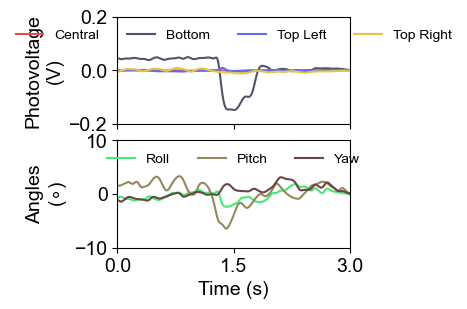

In [21]:
start = 34.7
offset = 0

start += offset
length = 3

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/anti-motion/motion.svg', bbox_inches='tight', dpi=600)
plt.show()

# Video

## video1

In [23]:
path = '../dataset/revision/'
target_date = '2024-09-05'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,353.278,0.3804,0.2744,0.3203,0.5231,9.5007,72.7064,179.6988
1,353.328,0.3800,0.2693,0.3200,0.5230,11.1127,72.9946,181.2831
2,353.378,0.3804,0.2678,0.3199,0.5229,12.7437,73.2743,182.8868
3,353.428,0.3803,0.2674,0.3198,0.5230,15.0863,73.3989,185.2966
4,353.478,0.3799,0.2660,0.3195,0.5231,16.7035,73.7219,186.8927
...,...,...,...,...,...,...,...,...
935,401.228,0.3823,0.5296,0.3096,0.5258,25.1670,76.0773,257.0264
936,401.278,0.3819,0.5323,0.3099,0.5259,27.7778,75.9547,259.7380
937,401.328,0.3820,0.5336,0.3101,0.5260,25.3652,76.0269,257.3856
938,401.378,0.3823,0.5294,0.3103,0.5264,27.5463,76.1677,259.4540


In [24]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [25]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,353.278,0.380400,0.274400,0.320300,0.523100,9.500700,72.706400,179.698800
1,353.279,0.380398,0.274130,0.320283,0.523090,9.575474,72.727829,179.769400
2,353.280,0.380396,0.273868,0.320267,0.523080,9.649822,72.748733,179.839736
3,353.281,0.380395,0.273612,0.320251,0.523070,9.723744,72.769120,179.909808
4,353.282,0.380393,0.273364,0.320236,0.523061,9.797244,72.788996,179.979614
...,...,...,...,...,...,...,...,...
48096,401.374,0.382575,0.525498,0.310486,0.526522,26.363569,76.055785,258.381405
48097,401.375,0.382581,0.525468,0.310489,0.526517,26.210048,76.048704,258.236362
48098,401.376,0.382588,0.525442,0.310493,0.526512,26.049112,76.041381,258.084242
48099,401.377,0.382594,0.525419,0.310496,0.526506,25.880637,76.033814,257.924928


In [26]:
# butterworth filter
cutoff = [0.01, 20]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,0.005196,-0.058408,0.005225,0.000749,-0.986831,2.066549,-2.424695
1,0.001,0.005195,-0.058637,0.005212,0.000740,-0.916222,2.084818,-2.357645
2,0.002,0.005194,-0.058868,0.005198,0.000732,-0.844819,2.103213,-2.289809
3,0.003,0.005193,-0.059099,0.005184,0.000724,-0.772776,2.121673,-2.221329
4,0.004,0.005192,-0.059331,0.005171,0.000715,-0.700241,2.140140,-2.152337
...,...,...,...,...,...,...,...,...
48096,48.096,-0.000042,0.000315,-0.000026,0.000032,1.038402,0.054160,1.000291
48097,48.097,-0.000037,0.000277,-0.000023,0.000029,0.932094,0.048480,0.897814
48098,48.098,-0.000033,0.000242,-0.000020,0.000026,0.828371,0.042978,0.797850
48099,48.099,-0.000029,0.000209,-0.000017,0.000023,0.728051,0.037691,0.701184


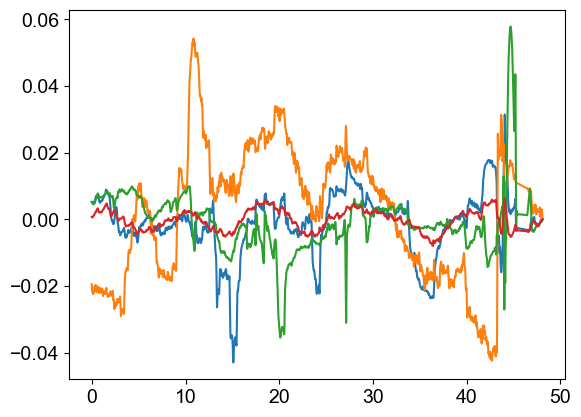

In [27]:
high_res_df['pd2'] /= 3

plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
# plt.xlim(831, 900)
# plt.ylim(-0.01, 0.01)

In [28]:
# audio = AudioSegment.from_file('../dataset/revision/video1.m4a')
# audio.export('../dataset/revision/video1.wav', format='wav')

In [29]:
y, sr = librosa.load('../dataset/revision/video1.wav', sr=None)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, n_fft=8192, hop_length=1024)
S_dB = librosa.power_to_db(S, ref=np.max)

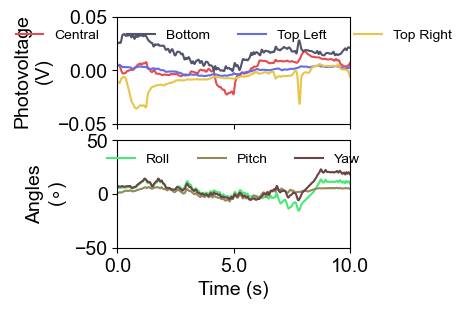

In [31]:
start = 1.3
offset = 18

start += offset
length = 10

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.05, 0.05)
ax1.set_yticks([-0.05, 0, 0.05])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-50, 50)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/video/video1.svg', bbox_inches='tight', dpi=600)
plt.show()

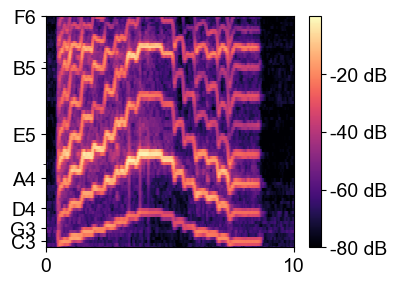

In [9]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.xlim(9, 13)
plt.ylim(100, 1000)

plt.xticks([9, 13], labels=[0, 10])
plt.yticks(list(note_freqs.values())[0::4], list(note_freqs.keys())[0::4],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/video/video1_spec.png', bbox_inches='tight', dpi=600)
plt.show()

## video2

In [14]:
path = '../dataset/revision/'
target_date = '2024-09-06'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,85.578,0.3733,0.5704,0.3220,0.5374,20.9147,71.3402,266.7076
1,85.628,0.3731,0.5648,0.3221,0.5373,21.3836,71.9293,267.3642
2,85.678,0.3730,0.5703,0.3219,0.5369,21.7474,72.2369,267.6991
3,85.728,0.3718,0.5711,0.3218,0.5366,21.4929,72.6185,267.3413
4,85.778,0.3714,0.5703,0.3215,0.5365,20.3723,73.1158,265.9169
...,...,...,...,...,...,...,...,...
816,126.378,0.3928,0.5679,0.3393,0.5440,18.3586,68.6531,322.4705
817,126.428,0.3925,0.5666,0.3394,0.5439,19.7955,68.4634,323.9927
818,126.478,0.3928,0.5693,0.3393,0.5435,21.7157,68.4086,325.7914
819,126.528,0.3914,0.5713,0.3385,0.5429,20.6038,68.5789,324.8650


In [15]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [16]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,85.578,0.373300,0.570400,0.322000,0.537400,20.914700,71.340200,266.707600
1,85.579,0.373280,0.570044,0.322009,0.537404,20.922451,71.357377,266.722761
2,85.580,0.373260,0.569700,0.322017,0.537407,20.930321,71.374281,266.737862
3,85.581,0.373242,0.569369,0.322025,0.537410,20.938307,71.390917,266.752901
4,85.582,0.373225,0.569050,0.322033,0.537413,20.946405,71.407286,266.767877
...,...,...,...,...,...,...,...,...
40995,126.573,0.390463,0.568935,0.338077,0.542764,18.736212,68.799469,323.159298
40996,126.574,0.390467,0.568815,0.338080,0.542770,18.706878,68.804121,323.129961
40997,126.575,0.390473,0.568691,0.338084,0.542777,18.678531,68.808741,323.101378
40998,126.576,0.390480,0.568564,0.338089,0.542784,18.651199,68.813329,323.073574


In [17]:
# butterworth filter
cutoff = [0.01, 20]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,-0.003016,0.034824,-0.001700,0.005189,9.609061,-0.249042,3.389716
1,0.001,-0.003031,0.034545,-0.001694,0.005191,9.617639,-0.233705,3.403935
2,0.002,-0.003046,0.034264,-0.001687,0.005193,9.626340,-0.218230,3.418320
3,0.003,-0.003061,0.033984,-0.001681,0.005195,9.635153,-0.202660,3.432839
4,0.004,-0.003075,0.033705,-0.001675,0.005197,9.644070,-0.187034,3.447464
...,...,...,...,...,...,...,...,...
40995,40.995,-0.000003,0.000895,-0.000007,-0.000032,0.245613,-0.036494,0.255723
40996,40.996,-0.000004,0.000800,-0.000007,-0.000029,0.217828,-0.032472,0.227056
40997,40.997,-0.000005,0.000709,-0.000007,-0.000026,0.191506,-0.028634,0.199827
40998,40.998,-0.000005,0.000621,-0.000006,-0.000023,0.166712,-0.024993,0.174118


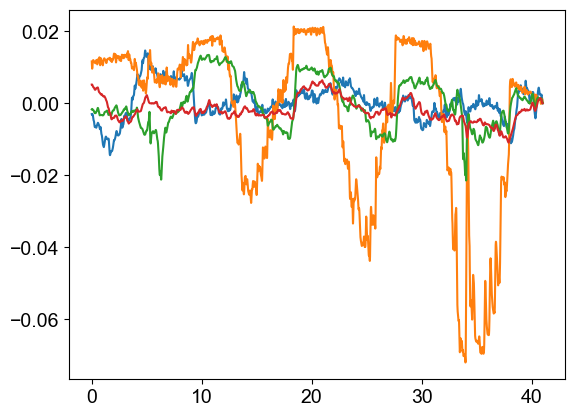

In [18]:
high_res_df['pd2'] /= 3

plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
# plt.xlim(831, 900)
# plt.ylim(-0.01, 0.01)

In [10]:
y, sr = librosa.load('../dataset/revision/video2.wav', sr=None)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, n_fft=8192, hop_length=1024)
S_dB = librosa.power_to_db(S, ref=np.max)

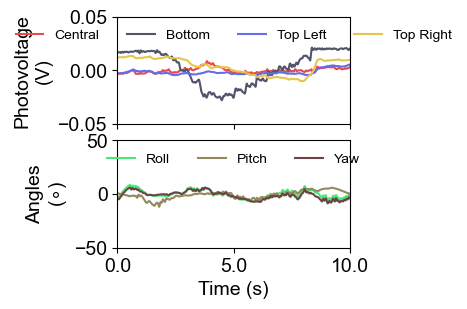

In [22]:
start = 0
offset = 10

start += offset
length = 10

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.05, 0.05)
ax1.set_yticks([-0.05, 0, 0.05])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-50, 50)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/video/video2.svg', bbox_inches='tight', dpi=600)
plt.show()

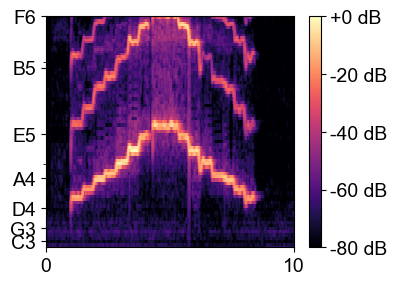

In [12]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.xlim(9, 14)
plt.ylim(100, 1000)

plt.xticks([9, 14], labels=[0, 10])
plt.yticks(list(note_freqs.values())[0::4], list(note_freqs.keys())[0::4],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/video/video2_spec.png', bbox_inches='tight', dpi=600)
plt.show()

# EMG

## LaHMo data

In [2]:
path = '../dataset/revision/'
target_date = '2024-09-10'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,84.078,0.3179,0.0040,0.2960,0.5013,-8.5074,4.5308,181.9829
1,84.128,0.3171,0.0040,0.2925,0.4959,-3.4434,7.7509,180.6785
2,84.178,0.3178,0.0040,0.2935,0.4951,-2.8687,8.4233,180.1888
3,84.228,0.3190,0.0040,0.2935,0.4949,-6.9521,3.3706,183.0119
4,84.278,0.3153,0.0039,0.2926,0.4939,-6.9665,3.9765,183.1158
...,...,...,...,...,...,...,...,...
1507,162.728,0.3206,0.0040,0.3093,0.4353,8.6934,37.5977,304.7151
1508,162.778,0.3194,0.0040,0.3093,0.4345,9.1544,37.1871,304.7415
1509,162.828,0.3186,0.0039,0.3058,0.4330,8.6087,37.2580,304.3898
1510,162.878,0.3185,0.0040,0.3029,0.4394,8.6640,37.4382,304.7770


In [3]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [4]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal

high_res_df['pd2'] *= 3

high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,84.078,0.317900,0.012000,0.296000,0.501300,-8.507400,4.530800,181.982900
1,84.079,0.317876,0.012002,0.295840,0.501119,-8.386631,4.565884,181.985674
2,84.080,0.317851,0.012003,0.295684,0.500942,-8.266172,4.603240,181.986541
3,84.081,0.317828,0.012005,0.295533,0.500768,-8.146054,4.642799,181.985546
4,84.082,0.317804,0.012006,0.295386,0.500597,-8.026307,4.684495,181.982736
...,...,...,...,...,...,...,...,...
78845,162.923,0.318025,0.011810,0.303724,0.450936,8.580543,37.291604,304.935982
78846,162.924,0.318001,0.011790,0.303794,0.451227,8.566642,37.282417,304.927431
78847,162.925,0.317977,0.011769,0.303867,0.451519,8.551992,37.272916,304.918141
78848,162.926,0.317952,0.011747,0.303942,0.451812,8.536578,37.263099,304.908098


In [5]:
# butterworth filter
cutoff = [0.1, 20]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,0.003031,0.000223,-0.001613,0.001625,3.776405,-4.690304,-1.351502
1,0.001,0.003010,0.000225,-0.001747,0.001468,3.893038,-4.648990,-1.360292
2,0.002,0.002989,0.000226,-0.001881,0.001310,4.011013,-4.606721,-1.369510
3,0.003,0.002968,0.000227,-0.002015,0.001151,4.130076,-4.563489,-1.379228
4,0.004,0.002947,0.000228,-0.002149,0.000991,4.249990,-4.519276,-1.389520
...,...,...,...,...,...,...,...,...
78845,78.845,0.000156,0.000147,-0.000548,-0.002102,0.089093,0.054082,0.031607
78846,78.846,0.000140,0.000132,-0.000490,-0.001872,0.080054,0.048474,0.028863
78847,78.847,0.000124,0.000117,-0.000435,-0.001653,0.071208,0.043022,0.026037
78848,78.848,0.000109,0.000103,-0.000381,-0.001444,0.062631,0.037766,0.023181


(50.0, 70.0)

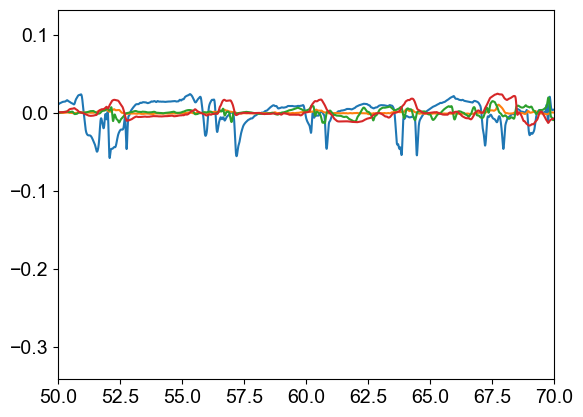

In [6]:
plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
plt.xlim(50, 70)
# plt.ylim(-0.01, 0.01)

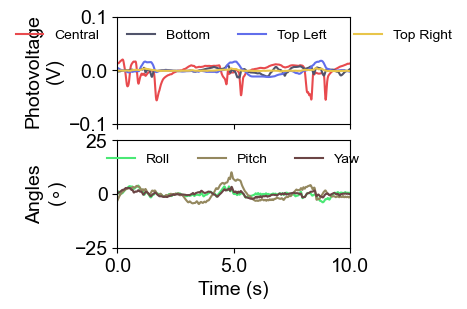

In [10]:
start = 0
offset = 55.5

start += offset
length = 10

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.1, 0.1)
ax1.set_yticks([-0.1, 0, 0.1])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/new tests/emg/swallowing_emg.svg', bbox_inches='tight', dpi=600)
plt.show()

## PowerLab

In [34]:
path = '..\\results\\revision\\new tests\\emg'
filename = 'revision-swallowing.txt'

filepath = os.path.join(path, filename)
df = pd.read_csv(filepath, header=None, skiprows=6, delimiter='\t')

df

,0,1,2,3,4
0,0.00000,-0.002540,0.001496,-0.000996,0.008865
1,0.00001,-0.002540,0.001496,-0.000996,0.008865
2,0.00002,-0.002540,0.001496,-0.000996,0.008865
3,0.00003,-0.002540,0.001496,-0.000996,0.008865
4,0.00004,-0.002540,0.001496,-0.000996,0.008865
...,...,...,...,...,...
6069995,60.69995,0.009069,0.002950,-0.003953,0.008919
6069996,60.69996,0.009057,0.002931,-0.003947,0.008928
6069997,60.69997,0.009045,0.002913,-0.003941,0.008938
6069998,60.69998,0.009033,0.002894,-0.003935,0.008948


(-0.2, 0.2)

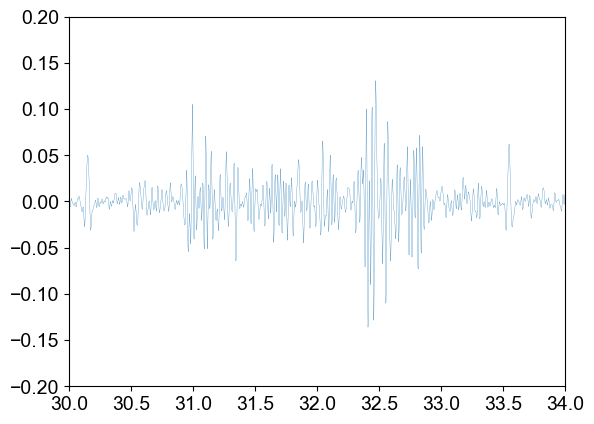

In [46]:
plt.plot(df[0], df[2], lw=0.2)
plt.xlim(30, 34)
plt.ylim(-0.2, 0.2)